In [4]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import plotly.express as px
import os
import re
from sklearn.linear_model import LinearRegression
from datetime import datetime

In [5]:
########### Load in Data #############

# Food Pricing (Relative Price Index)
food_pricing_path = r"Data/Pricing/RPI"

cereals_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_cereals.csv',
    header=8,
    usecols = ['Date', 'Price'],
    names=['Date', 'Price']
    )
cereals_pricing['Produce'] = 'Cereals'

eggs_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_eggs.csv',
    header=8,
    usecols = ['Date', 'Price'],
    names=['Date', 'Price']
    )
eggs_pricing['Produce'] = 'Eggs'

fruit_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_fruit.csv',
    header=8,
    usecols = ['Date', 'Price'],
    names=['Date', 'Price']
    )
fruit_pricing['Produce'] = 'Fruit'

poultry_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_poultry.csv',
    header=8,
    usecols = ['Date', 'Price'],
    names=['Date', 'Price']
    )
poultry_pricing['Produce'] = 'Poultry'

sugar_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_sugarandpreserves.csv',
    header=8,
    usecols = ['Date', 'Price'],
    names=['Date', 'Price']
    )
sugar_pricing['Produce'] = 'Sugar'

veg_pricing = pd.read_csv(
    f'{food_pricing_path}/RPI_vegetables.csv',
    header=8,
    usecols = ['Date', 'Price'],
    names=['Date', 'Price']
    )
veg_pricing['Produce'] = 'Vegetables'



In [6]:
def pricing_tidy_up(df):
    # Convert date column to datetime type
    def convert_to_yyyymmdd(date_string):
        datetime_obj = datetime.strptime(date_string, '%d/%m/%Y')
        return datetime_obj.strftime('%Y%m%d')

    # Apply the custom function to each element in the 'date' column
    df['Date'] = df['Date'].apply(convert_to_yyyymmdd)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

    # Sort the DataFrame by Date
    df.sort_values(by='Date', inplace=True)
    #monthly_std = df.groupby('Month')[:3].std()

    # Fit linear regression
    X = np.arange(len(df)).reshape(-1, 1) # Using row numbers as index for linear regression
    y = df['Price'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)

    # Predict values
    predicted_values = reg.predict(X)
    residuals = y - predicted_values

    # Add predicted values to DataFrame
    df['Predicted_Value'] = predicted_values
    std_dev = np.std(df['Price'])
    df['Outlier'] = np.where(abs(residuals) >= 1 * std_dev, 1, 0)


    return df

pricing_data = pd.concat([pricing_tidy_up(veg_pricing),pricing_tidy_up(sugar_pricing),pricing_tidy_up(poultry_pricing),pricing_tidy_up(fruit_pricing),pricing_tidy_up(eggs_pricing),pricing_tidy_up(cereals_pricing)])
pricing_data[pricing_data['Outlier'] == 1]

,Date,Price,Produce,Predicted_Value,Outlier
431,2022-12-01,252.0,Sugar,216.797970,1
432,2023-01-01,256.4,Sugar,217.038755,1
433,2023-02-01,256.3,Sugar,217.279540,1
434,2023-03-01,258.8,Sugar,217.520325,1
435,2023-04-01,262.5,Sugar,217.761110,1
...,...,...,...,...,...
291,2011-04-01,271.0,Eggs,207.006385,1
292,2011-05-01,272.6,Eggs,207.372164,1
293,2011-06-01,270.8,Eggs,207.737943,1
294,2011-07-01,271.8,Eggs,208.103722,1


Immediately we can see that sugar and poultry are the most volatile categories

<Axes: xlabel='Date', ylabel='Price'>

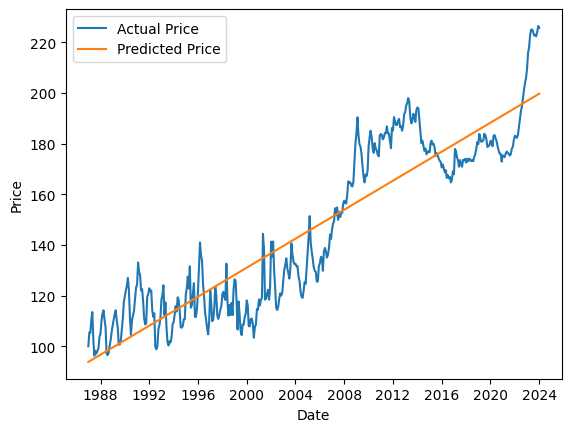

In [7]:
sns.lineplot(x='Date', y='Price', data=veg_pricing, label='Actual Price')
sns.lineplot(x='Date', y='Predicted_Value', data=veg_pricing, label='Predicted Price')

In [8]:
# Locate the temp and precipitation for the station code
def find_weather_data(code = '1', property = 'Temperature'):
    path = f"Data/Weather/{property}"
    pattern = re.compile(fr".*0{code}\.txt$")
    matching_data = []

    for root, _, files in os.walk(f"{path}"):
        for file in files:
            if pattern.match(file):
                file_path = os.path.join(root, file)
                #print(file_path)
                if 'RR' in file_path:
                    columns = ['Station', 'Source', 'Date', 'Rainfall', 'Quality'] 
                else:
                    columns = ['Station', 'Source', 'Date', 'Temp', 'Quality'] 
                    
                # Quality: (0='valid'; 1 ='suspect'; 9 ='missing')
                # Mean Temp: in 0.1 scale to 171 = 17.1

                # Read the CSV file, skipping the rows until the header
                matching_data = pd.read_csv(f'{file_path}', skiprows=21, names=columns, delimiter=',')
                matching_data['Date'] = pd.to_datetime(matching_data['Date'], format='%Y%m%d')
                
    return matching_data

#x = find_weather_data('2190', property = 'Temperature')
#x

In [15]:
find_weather_data('739', property = 'Temperature')

,Station,Source,Date,Temp,Quality
0,739,4049,2012-05-01,-9999,9
1,739,4049,2012-05-02,-9999,9
2,739,4049,2012-05-03,-9999,9
3,739,4049,2012-05-04,-9999,9
4,739,4049,2012-05-05,-9999,9
...,...,...,...,...,...
4288,739,907072,2024-01-27,22,0
4289,739,907072,2024-01-28,40,0
4290,739,907072,2024-01-29,78,0
4291,739,907072,2024-01-30,85,0


In [9]:
# Clean the weather data and add staticstical properties for later analysis
def weather_tidy_up(input):
    data = input[input['Quality'] != 9] # Delete any rows with missing data
    
    #pd.to_datetime(data['Date'], format='%d%m%Y')
    #input['Date'] = pd.to_datetime(input['Date'], unit='s')
    #input['Date'] = input['Date'].apply(lambda x: x.strftime('%d-%m-%Y'))
    
    if 'Temp' in data.columns:
        prop = 'Temp'
    else:
        prop = 'Rainfall'
    
    # Standard deviation column for months
    data['Month'] = data['Date'].dt.month
    monthly_std = data.groupby('Month')[prop].std()
    data['STD'] = data['Month'].map(monthly_std)
    
    # Add monthly mean temp
    monthly_mean = data.groupby('Month')[prop].mean()
    data['Monthly Mean'] = data['Month'].map(monthly_mean)
    
    # Calculate upper and lower bounds for outliers
    threshold = 1 #STD
    data['Upper Bound'] = data['Monthly Mean'] +  threshold * data['STD']
    data['Lower Bound'] = data['Monthly Mean'] - threshold * data['STD']

    # Identify outliers
    if prop == 'Rainfall':
        #print('\nRainfall\n')
        outliers = []
        count = 0
        period = 3 # amount of sustained days of abnormal temp
        
        for i , row in data.iterrows():
            
            if ((row[prop] > row['Upper Bound']) or (row[prop] < row['Lower Bound'])):
               
                if count >= period:
                    #print(count)
                    outliers.append(1)
                elif count < period:
                    outliers.append(0)
                    
                count += 1
                
            else:
                outliers.append(0)
                count = 0
                
        addition = pd.DataFrame({'Outlier':outliers})
        data = pd.concat([data, addition], axis = 1)
        
    elif prop == 'Temp':
        #print('\nTemp\n')
        outliers = []
        count = 0
        period = 7 # amount of sustained days of abnormal temp
        
        for i, row in data.iterrows():
            
            temp = row['Temp']
            if (int(temp) >= 300 or int(temp) <= 10):
                
                if count >= period:
                    outliers.append(1)
                elif count < period:
                    outliers.append(0)
                    
                count += 1
                
            else:
                outliers.append(0)
                count = 0
            #print(count)
                
        addition = pd.DataFrame({'Outlier':outliers})
        #print(f'\naddition: {len(addition)}\n')
        #print(f'\ndata: {len(data)}\n')
        data = pd.concat([data, addition], axis = 1)
    #data['Date'] = data['Date'].dt.strftime('%d/%m/%Y')
        
    
    return data[data['Station'] == data['Station']] # NaN in float64 type do not equal each other

#prepped_data = weather_tidy_up(find_weather_data('2190', property = 'Temperature'))
#prepped_data[prepped_data['Outlier'] == 1]


In [10]:
# Gather Data
temp_data = {
    'Reims': weather_tidy_up(find_weather_data('739', property = 'Temperature')),
    'Troyes': weather_tidy_up(find_weather_data('11243', property = 'Temperature')),
    'Lille': weather_tidy_up(find_weather_data('737', property = 'Temperature')),
    'Tours': weather_tidy_up(find_weather_data('2190', property = 'Temperature')),
    'Groningen': weather_tidy_up(find_weather_data('163', property = 'Temperature')), # Different temp and precipitation numbers for groningen
    'Lelystad': weather_tidy_up(find_weather_data('597', property = 'Temperature')),
    'Cork' : weather_tidy_up(find_weather_data('2136', property = 'Temperature')),
    'Galway' : weather_tidy_up(find_weather_data('441', property = 'Temperature')),
    'Kilkenny' : weather_tidy_up(find_weather_data('2138', property = 'Temperature'))
}

prec_data = {
    'Reims': weather_tidy_up(find_weather_data('739', property = 'Precipitation')),
    'Troyes': weather_tidy_up(find_weather_data('11243', property = 'Precipitation')),
    'Lille': weather_tidy_up(find_weather_data('737', property = 'Precipitation')),
    'Tours': weather_tidy_up(find_weather_data('2190', property = 'Precipitation')),
    'Groningen': weather_tidy_up(find_weather_data('147', property = 'Precipitation')),
    'Lelystad': weather_tidy_up(find_weather_data('597', property = 'Precipitation')),
    'Cork' : weather_tidy_up(find_weather_data('2136', property = 'Precipitation')),
    'Galway' : weather_tidy_up(find_weather_data('441', property = 'Precipitation')),
    'Kilkenny' : weather_tidy_up(find_weather_data('2138', property = 'Precipitation'))
}



C:\Users\edwar\AppData\Local\Temp\ipykernel_26460\2970642878.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month'] = data['Date'].dt.month
C:\Users\edwar\AppData\Local\Temp\ipykernel_26460\2970642878.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['STD'] = data['Month'].map(monthly_std)
C:\Users\edwar\AppData\Local\Temp\ipykernel_26460\2970642878.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [84]:
# at the same dates, simply columnise the location specific data
def simple_weather(input, property, location):
    data = input
    data = input[input['Quality'] != 9]
    data.drop(['Quality','Station','Source'], axis=1, inplace = True)
    if property == 'Temperature':
        data.rename(columns = {'Temp':location}, inplace = True)
    elif property == 'Precipitation':
        data.rename({'Rainfall':location}, inplace = True)
     
    return data

In [85]:
locations = {'739':'Reims', '11243':'Troyes', '737':'Lille', '2190':'Tours', '163':'Groningen','597':'Lelystad','2136':'Cork', '441':'Galway', '2138':'Kilkenny'}
grouped_temp_data = pd.DataFrame()
for loc_code in locations:
    #print(locations[loc])
    loc_data = simple_weather(find_weather_data(loc_code, property = 'Temperature'), property='Temperature', location=locations[loc_code])
    print(loc_data)
    if grouped_temp_data.empty:
        grouped_temp_data = loc_data
        print('empty')
    else:    
        grouped_temp_data = grouped_temp_data.merge(loc_data, on='Date', how='left')


C:\Users\edwar\AppData\Local\Temp\ipykernel_26460\984485679.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['Quality','Station','Source'], axis=1, inplace = True)
C:\Users\edwar\AppData\Local\Temp\ipykernel_26460\984485679.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns = {'Temp':location}, inplace = True)
C:\Users\edwar\AppData\Local\Temp\ipykernel_26460\984485679.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

           Date  Reims
7    2012-05-08    126
8    2012-05-09    174
9    2012-05-10    200
10   2012-05-11    180
11   2012-05-12    124
...         ...    ...
4288 2024-01-27     22
4289 2024-01-28     40
4290 2024-01-29     78
4291 2024-01-30     85
4292 2024-01-31     60

[4284 rows x 2 columns]
empty
            Date  Troyes
0     1975-05-01      82
1     1975-05-02     101
2     1975-05-03      96
3     1975-05-04      76
4     1975-05-05      92
...          ...     ...
17803 2024-01-27      18
17804 2024-01-28      51
17805 2024-01-29      84
17806 2024-01-30      93
17807 2024-01-31      90

[17808 rows x 2 columns]
            Date  Lille
0     1944-12-01     78
1     1944-12-02     63
2     1944-12-03     64
3     1944-12-04     68
4     1944-12-05     53
...          ...    ...
28911 2024-01-27     34
28912 2024-01-28     44
28913 2024-01-29     67
28914 2024-01-30     90
28915 2024-01-31     73

[28912 rows x 2 columns]
            Date  Tours
0     1959-11-01     84
1    

C:\Users\edwar\AppData\Local\Temp\ipykernel_26460\984485679.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['Quality','Station','Source'], axis=1, inplace = True)
C:\Users\edwar\AppData\Local\Temp\ipykernel_26460\984485679.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns = {'Temp':location}, inplace = True)
C:\Users\edwar\AppData\Local\Temp\ipykernel_26460\984485679.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [88]:
grouped_temp_data
grouped_temp_data.to_csv('grouped_temp',index=False)

In [11]:
a = prec_data['Kilkenny']
a

,Station,Source,Date,Rainfall,Quality,Month,STD,Monthly Mean,Upper Bound,Lower Bound,Outlier
2,2138.0,7866.0,1957-06-03,10.0,0.0,6.0,41.398660,25.246661,66.645321,-16.152000,0.0
4,2138.0,7866.0,1957-06-05,0.0,0.0,6.0,41.398660,25.246661,66.645321,-16.152000,0.0
5,2138.0,7866.0,1957-06-06,31.0,0.0,6.0,41.398660,25.246661,66.645321,-16.152000,0.0
6,2138.0,7866.0,1957-06-07,60.0,0.0,6.0,41.398660,25.246661,66.645321,-16.152000,0.0
7,2138.0,7866.0,1957-06-08,209.0,0.0,6.0,41.398660,25.246661,66.645321,-16.152000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
18562,2138.0,7866.0,2008-03-27,56.0,0.0,3.0,39.551076,25.942834,65.493910,-13.608242,NaN
18563,2138.0,7866.0,2008-03-28,32.0,0.0,3.0,39.551076,25.942834,65.493910,-13.608242,NaN
18564,2138.0,7866.0,2008-03-29,32.0,0.0,3.0,39.551076,25.942834,65.493910,-13.608242,NaN
18565,2138.0,7866.0,2008-03-30,247.0,0.0,3.0,39.551076,25.942834,65.493910,-13.608242,NaN


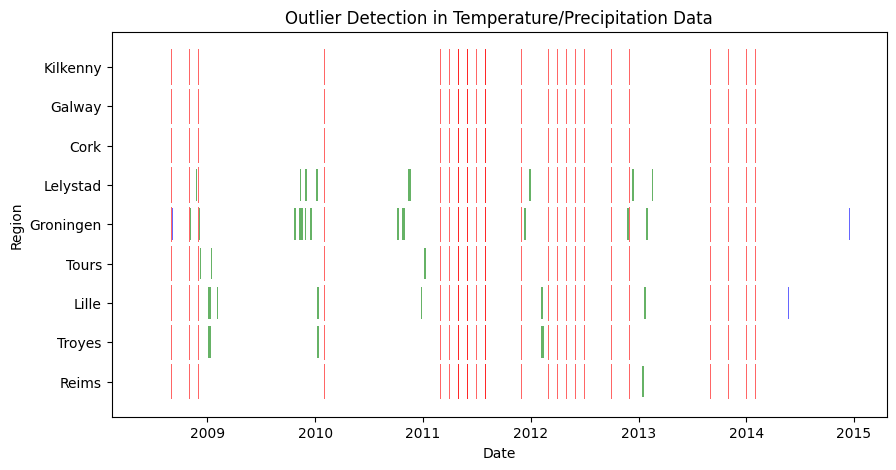

In [12]:
# Sample data: Dates and corresponding events (True/False)

# Define duration (1 day in this case)
duration = pd.Timedelta(days=1)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

l_cutoff = '2008-01-01'
u_cutoff = '2016-01-01'
pricing = pricing_data[(pricing_data['Date'] > l_cutoff) & (pricing_data['Date'] < u_cutoff)]


for region in prec_data.keys(): 
               
    for i, row in pricing.iterrows():
        if row['Outlier'] == 1:
                color = 'red'  # Green for True, Red for False
                ax.barh(region, duration, left = row['Date'] , color=color, alpha=0.6, height = 0.9 )

# Iterate through each region in temp_data
for region, df in temp_data.items():
    # Iterate through each row in the DataFrame for the current region and plot the event
    df = df[(df['Date'] > l_cutoff) & (df['Date'] < u_cutoff)]
    
    for i, row in df.iterrows():
        if row['Outlier'] == 1:
            color = 'green'  # Green for True, Red for False
            ax.barh(region, duration, left = row['Date'] , color = color, alpha=0.6)
            
for region, df in prec_data.items():
    # Iterate through each row in the DataFrame for the current region and plot the event
    df = df[(df['Date'] > l_cutoff) & (df['Date'] < u_cutoff)]
    for i, row in df.iterrows():
        if row['Outlier'] == 1:
            color = 'blue'  
            ax.barh(region, duration, left = row['Date'] , color=color, alpha=0.6)



# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Region')
ax.set_title('Outlier Detection in Temperature/Precipitation Data')

# Set x-axis date format
ax.xaxis_date()

# Show plot
plt.show()

Just picking out daily outliers above 2 std isnt going make clear the effects, so I am taking a slightly different approach trying to identify periods of sustained temperature or precipitation. Perhapds even identifying key months where they happen.

Another thing to point out: most of the price spikes come in January which feels rather like there is a problem with the data. On the other hand it could just be a frost that kills chicken feed thats growing.

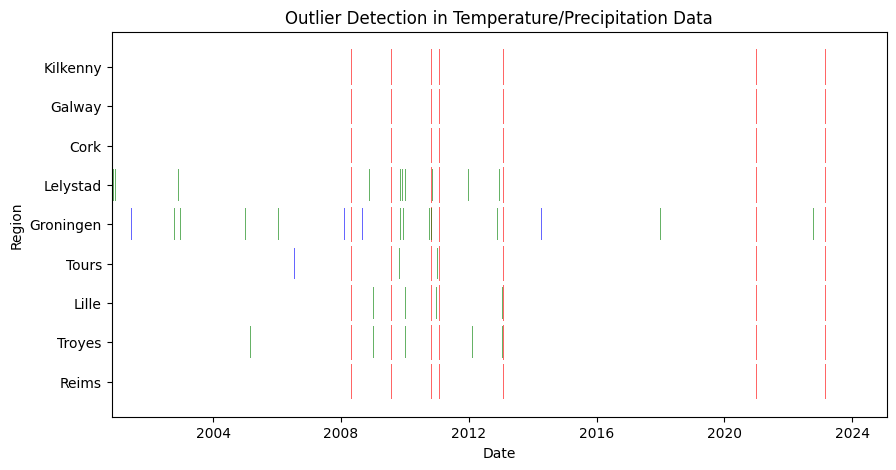

In [13]:
# Define duration (1 day in this case)
duration = pd.Timedelta(days=1)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

l_cutoff = '2000-01-01'
u_cutoff = '2024-01-01'
pricing = pricing_data[(pricing_data['Date'] > l_cutoff) & (pricing_data['Date'] < u_cutoff)]


for region in prec_data.keys(): 
               
    for i, row in pricing.iterrows():
        if row['Outlier'] == 1:
                color = 'red'  # Green for True, Red for False
                ax.barh(region, duration, left = row['Date'] , color=color, alpha=0.6, height = 0.9 )

# Iterate through each region in temp_data
for region, df in temp_data.items():
    # Iterate through each row in the DataFrame for the current region and plot the event
    df = df[(df['Date'] > l_cutoff) & (df['Date'] < u_cutoff)]
    
    for i, row in df.iterrows():
        if row['Outlier'] == 1:
            color = 'green'  # Green for True, Red for False
            ax.barh(region, duration, left = row['Date'] , color = color, alpha=0.6)
            
for region, df in prec_data.items():
    # Iterate through each row in the DataFrame for the current region and plot the event
    df = df[(df['Date'] > l_cutoff) & (df['Date'] < u_cutoff)]
    for i, row in df.iterrows():
        if row['Outlier'] == 1:
            color = 'blue'  
            ax.barh(region, duration, left = row['Date'] , color=color, alpha=0.6)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Region')
ax.set_title('Outlier Detection in Temperature/Precipitation Data')

# Set x-axis date format
ax.xaxis_date()

# Show plot
plt.show()

In [14]:
# Function to check if there has been a temperature higher than 300 or lower than 0 for at least the past 5 days
df = temp_data['Reims']


for i,row in df.iterrows():
    count = 0
    if row['Temp'] > 300 or row['Temp'] < 10:
        if count >= 5:
            row['Outlier'] = True
        count += 1
    
    else:
        row['Outlier'] = False
        count = 0